# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 6419, 'TN': 55873, 'FP': 58789, 'FN': 6575, 'Accuracy': 0.48796766309456663, 'Precision': 0.09843884185989449, 'Recall': 0.4939972294905341, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12882, 'TN': 114576, 'FP': 86, 'FN': 112, 'Accuracy': 0.998448956570784, 'Precision': 0.993368291178285, 'Recall': 0.9913806372171772, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12926, 'TN': 114611, 'FP': 51, 'FN': 68, 'Accuracy': 0.9990678072319358, 'Precision': 0.9960699699468291, 'Recall': 0.9947668154532862, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12721, 'TN': 103334, 'FP': 11328, 'FN': 273, 'Accuracy': 0.9091229554427523, 'Precision': 0.5289617031893218, 'Recall': 0.9789903032168693, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12896, 'TN': 114603, 'FP': 59, 'FN': 98, 'Accuracy': 0.9987701322303691, 'Precision': 0.9954457738324971, 'Recall': 0.99245805756503, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 10953, 'TN': 114475, 'FP': 187, 'FN': 2041, 'Accuracy': 0.9825468446449834, 'Precision': 0.983213644524237, 'Recall': 0.8429275050023087, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yujunjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12994, 'Neg': 114662, 'TP': 0, 'TN': 114662, 'FP': 0, 'FN': 12994, 'Accuracy': 0.8982108165695306, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yujunjiang/Desktop/Machine Learning/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

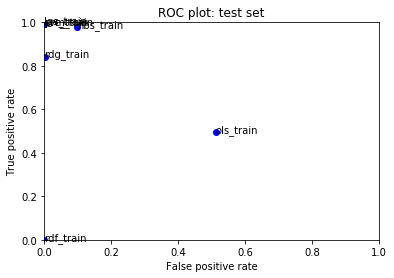

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
3
"  Also, did you know that Mainstream Lutherans have considered ""evangelicals"" a ""cult""?    Like I said, it's all subjective and biased."
* * * * * * * * * 
10
Sorry for the late response. Heres the soruce saying that Mac Walters is the lead writer... http://blog.bioware.com/2009/10/15/preview-the-dark-horse-mass-effect-comic/   5:19, 25 October 2009 UTC
* * * * * * * * * 
74
hahaha ok im sorry i just wanted to see if u could do me a favour but its cool i understand.. im just curious how old u r its not that big a deal is it.. and also.. since ud kno a lot bout computers.. i have this spyware thing n it comes up with warning every few mins sayin how im at risk n it made my homepage sumfin 2 do with downloading sum program 2 get rid of it.. n it keeps annoying me.. ne ideas?? thank u
* * * * * * * * * 
85
Just EXACTLY what I was expecting from this RAG!
* * * * * * * * * 
210
"

 rating Christian articles - just curious 

John you recently increased th

2553
"

Right, I reinserted a line from a long-standing FA version of this article because I could not understand why it was removed. The first part talks about how India has become one of the fastest growing economies and the the second addresses its continuing challenges. For the sake of neutrality, I found it strange that the ""however"" part was completely excised. Perhaps, one can work on better sourcing and I see Kkm has tweaked it.   "
* * * * * * * * * 
2564
"
Well, I'm glad that you're humble enough to be willing to engage in an intelligent discussion or perhaps even (gasp!) consider dissenting arguments to be slightly more than deletion fodder. Perhaps you might even be willing to consider the possibility that your opinions aren't be-all, end-all. Your justification leaves much room for POV, but I'm sure that's okay since you can always decide personally what is an ""indiscriminate collector of trivial information"" or a ""hideously colored"". After all, you're perfect!  "
* 

4978
Saudi Arabia government and islamofascism
I see that user:SlimVirgin reverted my edits without motivation. I would like to request her to give this motivation.  (Talk | Contribs 25px)
* * * * * * * * * 
5126
"
To say that they approached the topic with skepticism is to imply that they literally considered the possibility that this truly was a time traveler. That itself is a POV. I disagree and say that the reporters and anchors who reported the story were well aware that this was a joke and that debunking it was simply part of the satire. ""Debunking"" a time traveler is POV. And if it is satire it is clearly intentional unreliability. Reporting what something appears to be is a pseudoscience. Every year many news sources have ""Special Issues"" on April 1st. There is an understanding that on that date many pranks may be pulled. We laugh and then forget the jokes the next day, in my opinion. Orson Welles' ""War of the Worlds"" broadcast is notable because (amongst other things) of

7380
"
I'll start by quoting something a headmaster of mine once said:
""Don't bring me problems, bring me solutions.""
Ultimately, yes you will have to reason with people, and yes you will need to garner consensus. I've spoken to Matia, who is perfectly willing to try to strike for a middle ground; so we just need to find that middle ground.
I'm thinking of ways to help you guys work this one out - I'll come up with something in a few minutes, I hope.  Talk "
* * * * * * * * * 
7381
Nut butters?

You're not supposed to eat whole nuts or crunchy peanut butter on this diet, but it says its OK to eat oils.  Does that mean you can eat smooth     nut butters such as creamy peanut butter, almond butter, cashew butter, filbert butter, etc.?
* * * * * * * * * 
7385
"}}
It's been 24 hours, please unblock this IP immediately because Wikipedia ""blocking policy"" says ""incidents of disruptive behavior typically result in 24 hour blocks""  not week long blocks.  This is the first time block. The

9636
"

 Bibliography Section Added 

Joseph's co-authorship of The Zeitgeist Movement Defined has been added as it fits Wiki requirements for Biographies as far as what the person has produced in media. Just as the Films are noted and are, in truth, self-published, so would be his other works. This book was years in the making and isn't some ""blog"" or other non-notable literature   "
* * * * * * * * * 
9650
Yeah, you got some very solid support this go-round, things will probably go better next time. - Dank (push to talk)
* * * * * * * * * 
9655
Then dont come here if you dont like it?! 31.209.16.177
* * * * * * * * * 
9749
User:Acuman
This user should be banned. He has made derogatory comments, intentional fabricated controversial and untrue material into articles, and deliberately disturbed both order and balance in the Wiki-community. He has been in numerous exchanges with other users. User:Acuman also applies double standards he says one thing for others and sees himself above w

12277
Compliance is the ease with which a change occurs. For pulmonary compliance that means the relative amount of pressure needed to make a change in volume. As such emphysema and COPD are characterized by decreased compliance because more effort is needed to change the same amount of volume. The statement that Emphysema and COPD represent conditions with decreased compliance is incorrect and is probably confusing the increased lung volume that often accompanies those conditions. High lung compliance (low effort for the amount of volume change) is associated with healthy lungs.
* * * * * * * * * 
12368
Semi-protected edit request on 26 March 2014 

I wish to fix a lot of errors I see on this page.

Hay muchos errores en esta pagina, me gustaria contribuir.
* * * * * * * * * 
12411
"

 Please do not vandalize pages, as you did with this edit to Charles Durward Griffin. If you continue to do so, you will be blocked from editing.  Say Headcheese!-Chord2 "
* * * * * * * * * 
12442
Weapon

14722
Welcome!

Hello, , and welcome to Wikipedia! I hope you like the place and decide to stay.

There's a page about creating articles you may want to read called Your first article. If you are stuck, and looking for help, please come to the New contributors' help page, where experienced Wikipedians can answer any queries you have! Or, you can just type  on this page, and someone will show up shortly to answer your questions. Here are a few other good links for newcomers:
Your first article
Biographies of living persons
How to write a great article
The five pillars of Wikipedia
Help pages
Tutorial
I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you have any questions, check out Wikipedia:Where to ask a question or ask me on .  Again, welcome!
* * * * * * * * * 
14851
Ranze, there was no harassment or disruption. Note the lack of examples (diffs), or, if a dif

16879
I don't know how to use a proxy or how to stop using one, or how I ended up with one. How do I get rid of it?
* * * * * * * * * 
16885
Thank you for all of your excellent articles on naval vessels.  Keep up the good work!
* * * * * * * * * 
16911
Revert by DuncanHill
Further to above. Please take care with accusations. Not only are the rude but they do not encourage constructive working, and in this case you are mistaken. My change to William Gregor, from Cornish to British, was to be consistent with the description of [[Humphry Davy] and Davies Gilbert, both of who feature prominantly in the article on Royal Geological Society of Cornwall which you created. I also note that British is considerably more informtive to a worldwide readership - most will know of Britain but much fewer will be aware of Cornwall.
* * * * * * * * * 
17047
Ok, I looked into it, but there doesn't appear to be a specific annual event like you would normally expect that stands out, so I just tweeked this t

19087
Side Projects 

Such a plain list like it is now feels somehow wrong. Some are side projects of Bill, some of Rhys, some of Chris... It should be added for clarity.
* * * * * * * * * 
19106
, F(x)'s Koala, and Amazing f(x)
* * * * * * * * * 
19118
"

The oppose votes did not account for the substantial evidence that the Aguilera song is primary. If you want to discuss it I'm available, but unilaterally moving it back is not an option. t/c 

Stop move warring or the page will be protected. Please continue the discussion; I've responded to your comment at my talk page. t/c 
  It did account for it. The Oppose above mine did. If anything, the Pretty Ricky one should be the one which is not disambiguated because it was release in 2005, Aguilera's in 2012. Not having Aguilera's name appear in search results is not helpful. Oppose far outweighed support here, and you have no reason to overlook that.  —  • TALK   "
* * * * * * * * * 
19137
No  problems. If   says he wants to  reference 

21111
"

 Please stop your disruptive editing. If you continue to vandalize Wikipedia,  you will be blocked from editing.   talk • contribs "
* * * * * * * * * 
21142
o.k. talk to u tomorrow!!!!!!!!why the heck did he do that
* * * * * * * * * 
21340
It is too complicated for an encyclopedia, but wikipedia does not follow the norms on scientific topics...virtually all of their articles on science are too technical for an encyclopedia, and are essentially of little use to people who are not already studying the topics at an advanced level. An encyclopedia is a reference book that explains things in terms that a non-expert can understand, and wikipedia science articles generally fail to serve that function, but that seems to be the accepted practice.
* * * * * * * * * 
21452
An SPI
You are mentioned and may have an interest in Wikipedia:Sockpuppet investigations/ChildofMidnight. Thank you,
* * * * * * * * * 
21488
"

 Snowded/GoodDay's sandbox 

That is Snowded's sandbox that is a collec

23324
Real or fake? 
Is the footage shown in the show really taking place or is it just played by actors to look real? I only saw two episodes and wondered in some situations how they placed the camera in rooms they usually don't have access to. Regards from Austria.
* * * * * * * * * 
23348
, 8 June 2013 (UTC)

Ugh(again) And thank God for that. Thanks for correcting me.  14:05
* * * * * * * * * 
23357
then the stuff already put there .
* * * * * * * * * 
23367
Please use the talk page instead of abusing the article's history as your message-board.
* * * * * * * * * 
23370
"

 Pasting a biogaphy on my talkpage 

Dear Riazmt, I'm not sure why you would paste an entire biography on my talkpage. But I would suggest not to repeat this, as I'm not really sure what the point is.—♦♦ (ЯʘCK) "
* * * * * * * * * 
23438
"

Yep, user view obviously has no bearing on inclusion or not.

""Hard to argue?"": Are you conceding a keep-in? "
* * * * * * * * * 
23440
March 2009 
 Please stop your disrupt

25558
If you actually understood why your behavior was unacceptable, you wouldn't try to justify it. Regardless of what Bus Stop is doing, you need to own your frustration, and deal with it appropriately. No one is obligated to answer your questions or accept your arguments. 24.177.120.138
* * * * * * * * * 
25566
"

Call Sign Meaning
I've been adding WISconsiN as a call sign meaning for quite some time now only to have it deleted by another user who INSISTS that the only possible meaning for the calls is the defunct WISconsin News newspaper.  As far as I know, there is no official documentation or credible source that states that the calls are a reference to the newpaper and the newspaper ALONE.  So who's to say the calls weren't also chosen because it was an abbreviation of the state's name?  There's plenty of examples of a station using calls with multiple meanings (such as WBBM-TV out of Chicago).  But my main sticking point is that WISN has referenced the calls while advertising i

27889
"  

 And finally, I believe you're making a guileful, if rather inept use of the concept of ""original research"". I challenge you to find me reliable sources stating that 3*16=48. If possible, making such fact the center of the article or a relevant part thereof. Same here, with the additional fact that it is the producers and distributors who decide a relevant part of the critics' response to a filmand this is not conspiracy theory, this is basic market dynamics. The plot for Oculus contains the same relevant points as the one for The Boogeyman:
 * two siblings witness the death of their parents/mother's boyfriend at the hands of one of them, and the whole scene is preternaturally captured by a mirror
 * this happens after one of the siblings had been chained/tied up in their bedroom by the victims, then freed by the other sibling
 * years later the murderous sibling (in both cases the brother) is still psychologically scarred by the event
 * and murders and unnatural phenomen

30183
Huh, I plotted the CIE data and it's indeed rather different. Reading the reference I got my graph from, it seems its data comes directly from spectrophotometry of the cone cells themselves, but says that there's a whole bunch of processing that goes on after that, in the retinal membrane and the brain. This colour vision stuff is more complex that it looks.
* * * * * * * * * 
30198
Here is one for you
Kyra Gracie.  She is said to be the champion of a tournament that is run by her grandfather. .   With Ron Duncan you would delete individuals whom had sources based from his students, what of Kyra Gracie and her family relationship?
* * * * * * * * * 
30217
I had no intention of vandalizing Wikipedia.  While I may not share your views, I cherish this resource and will continue to do so regardless of how I feel I'm being treated.  Just because I own the website doesn't mean I placed it there for advertisement; I'll have you know I make no profit from it, as it is strictly a hobby.



32586
I told my cousin about what was going on hes always on that site. He probably made it. I have a question how do u make on of those boxs with text?
* * * * * * * * * 
32619
525th MI Brigade
It appears you manually moved the 525th BFSB to the 525th MI Brigade and in the process severed the article's history.  You can fix this by asking an administrator to re-move 525th Battlefield Surveillance Brigade to 525th Military Intelligence Brigade (United States) over the re-direct.  Regards,
* * * * * * * * * 
32640
Here are some quotes from Maudoodi's book. Obviously he is anti-democratic /anti-human rights; 

“In this Islamic government system there is not much room for a person to exercise his free will”
[Ref: Abul A’la Maududi, Tr Al-Ash’ari: A Short History of the Revivalist Movement in Islam, 1941]

“From political point of view, the theory of Islamic state is the very antithesis of Western secular democracy.”
[Ref: Abul A’la Maududi: Islamic Law and Constitution]

“Islam wants to d

35055
Wanted to add my welcome, and thanks for the help with DD-related work!  I do a lot of work in this area too, and it's always nice to have another pair of eyes and hands around.

One thing  we can't add just any photo scanned from a magazine (or found on the net), since the copyrights belong to the photographer.  Please read Wikipedia:Copyrights and Wikipedia:Image use policy for more details.  If you believe the photos you've added can be legitimately used here, please provide more information on your reasoning and the sources of your images on the photo's Image description page; otherwise I'm afraid many of them are going to have to be deleted.  It's a shame because you've put a lot of work into providing and placing great photos, but we have to be very careful to have legal rights to everything we put up here  Wikimedia is a non-profit organization which can't afford to be sued over this.  

I had to learn all this copyright stuff the hard way myself when I was looking for pho

37339
, next time I will consult or using sandbox first before posting an article.
* * * * * * * * * 
37487
If you're gonna reply like that then don't. Minutes later, another thread reduced to a slanging match. It's no wonder everyone's giving up on this article.
* * * * * * * * * 
37512
(UTC)

Yes, I was looking for info on Tetragonolobus purpureus aka Asparagus Pea. Purpurea? Help! Latin people. Maybe a new article with a pointerto clear the confusion? Good info from 203.111.229.86. (completely to off one´s trolley! excellent!)
  23:35, 5 June 2010
* * * * * * * * * 
37531
It would appear gabberfoxx that your edits are being not being made in good faith, as you knowingly alter the infobox information to be wrong.
* * * * * * * * * 
37551
"

We were going to do that here but never got around to it. -) I guess we'll have to deal with it after the US Open… —  "
* * * * * * * * * 
37586
My sense of humour 

I am inserting amusement into Wikipedia. Why the problem?
* * * * * * * * * 
3763

39624
Broken redirects 

Your redirects from Gesca, Gesca Ltée, Gesca Ltd. and [[Gesca Limited to Gesca Limitée are showing up on the Special:BrokenRedirects report. Are you planning to write an article?  (pigs can fly) 4 July 2005 12:57 (UTC)
* * * * * * * * * 
39648
NSW compromise 

I'm glad we could reach a compromise on this. I do recognise the enormous amount of work you've done on elections pages. No hard feelings?
* * * * * * * * * 
39728
But this is a real musical artist. Check WP:MUSIC
* * * * * * * * * 
39824
" 
Wikipedia has rules about presenting a neutral point of view.  Details can be found at Wikipedia:Neutral point of view.  The additions you made are not consistent with that policy because they present opinion and speculation as fact.  Apart from that, your additions phrases such as ""let's just say"", use ""you"" to address the reader, and have ""weasel words"" such as ""everybody says"".  This creates a tone that is completely inappropriate for an encyclopedia articl

41904
I think it's more important to have the infobox reflect the actual CREATOR, and discuss the current editors/contributors in the body of the article, since they so often change.
* * * * * * * * * 
41930
Possibly unfree Image:Wardbldg.jpg 
An image that you uploaded or altered, Image:Wardbldg.jpg, has been listed at Wikipedia:Possibly unfree images because its copyright status is disputed. If the image's copyright status cannot be verified, it may be deleted. You may find more information on the image description page. You are welcome to add comments to its entry at the discussion if you are interested in it not being deleted. Thank you. Iamunknown
* * * * * * * * * 
41936
The show itself can serve as source material. This has been discussed recently on the Y&R; page (and confirmed by a site admin): shows ARE valid sources. You can re-do the edits regarding John's parentage.
* * * * * * * * * 
41955
"
 On the contrary, that wasn't a revert. It was the addition of cited material. An

44054
Answer:

The Dutch 1895 mannlicher has nothing in common with this rifle, apart from the fact they were both made by Steyr!
They are totally different designs.
* * * * * * * * * 
44076
Welcome to wikipedia before you get sterted you have to learn how to make articles and a bunch of other stuff
* * * * * * * * * 
44079
I think this page should include a reference to the important free Go-playing program GNU Go.

In the absence of Wikipedia pages describing Go++, Many Faces of Go and GNU Go, why not provide external links to pages describing these programs?
* * * * * * * * * 
44081
Hi Kking2013. I went ahead and moved your sandbox which had an article on IMA World Health. I thought the subject to be notable and have moved it here  here.
* * * * * * * * * 
44188
Pope as the Antichrist

The article lets clear that the Church considers the pope as the Antichrist. Isn´t this enought anti-Catholic for you! I´m just being neutral.85.243.69.247
* * * * * * * * * 
44298
"

 I have extended

46245
"

How is it standing up to me? Look at the edit you are protecting the page from. How do you figure it was ""unconstructive""? Read the edit, I reverted back to what I had spent 10 minutes copy editing. That was quite constructive. Don't fall for Cosprings' lies. Now revert it back to what I edited. 72.66.80.133  "
* * * * * * * * * 
46255
vs Holocaust deniers
* * * * * * * * * 
46291
"

Career
I read this section 4 times. I couldn't find any mistakes. It is brilliantly written and already is of FA quality. Good work. TalkContributions "
* * * * * * * * * 
46330
"==In response to your feedback==

Paul.e.williamss, why are you sad? Is there something wrong? Aren't you comfortable with your stay at Wikipedia? 

  

 "
* * * * * * * * * 
46334
Winter war! 

You are a Finn?? I see! Must be a KGB insurgent in Finland no doubt. BTW prove me wrong boy!
* * * * * * * * * 
46349
"

Have made a start, to show willing! There are many more references but mostly in the academic literature, i

48347
It is difficult to know how to divide this material.  There is the pederasty/paedophilia distinction, which is partly one of age (under age of consent but pubescent, under age of consent but pre-pubescent); partly one of gender (pederasty is specifically boys - interesting as far as I can see that there are no articles concerning the ancient institutionalised practice of older men marrying young girls).  Partly one of the supposed acceptance of pederasty in old but non-Greek cultures (very little actual evidence for that I think) and finally the institutionalisation of pederasty in classical Greek culture.  All these should be handled differently.
* * * * * * * * * 
48386
"
As for your claims of ""stalking"", that is absolute rubbish and serves only to aggravate the situation. I have assumed good faith (and good intentions) on your part, and have never suggested (or seen reason to suggest) that you might have some ulterior motive in mass-adding links to one specific company's web

50674
That's fine.  I just won't do any of the CheckUsers I was going to do this evening.  Have a nice day.
* * * * * * * * * 
50681
You are wrong about this. He was described to me by one member of the Richardson Research Group as charming, deeply caring, a wonderful man. The reason he has taken the position he has is that along with the members of this MEDICAL research group of which he is a member he feels Sharpe and Wessely's IDEAS to be dangerous and wrong. As a lay reader and an ex-general synod member he is a man of high integrity. He has worked alongside many physicians who find the psychiatric paradigm to be absurd. These include Prof. Terry Daymond, Dr. Julia Newton, Dr. Byron Hyde, Dr. Vance Spence, Dr. Nigel Speight, Dr. John Richardson the list continues...AND these are physicians and scientists of great note.

alpinist
* * * * * * * * * 
50731
Please comment here: Talk:MMR_vaccine_controversy#How_to_include_this_in_this_article.
* * * * * * * * * 
50807
Thanks for the las

53088
"

That can be said in the lead.  I contend that if we are going to include one issue which has little weight, such as the response of local residents, then we certainly have to include something with much more weight, such as unions or the opinion of the country.  One can say ""as of"" in the lead. Be——Critical "
* * * * * * * * * 
53096
Todo speedy deletion candidates 

I do not think that these were speedy deletion candidates - they don't seem to be patent nonsense or obviously insane redirects. If you really want them gone, I'd reccomend Wikipedia:Redirects for deletion.  02:00, Aug 3, 2004 (UTC)
* * * * * * * * * 
53347
Modify the lead 

Shouldn't the lead be modified due to Benedicts resignation?
* * * * * * * * * 
53354
Jeez.  Twunchy is really obsessed.  I've re-edited the intro so that it incorporates about 80% of his words, but he still insists on reverting and refusing to discuss things on the Talk page.  I know you hate these things, but can you post something there j

55537
"Please Note: This page is watched many talk page stalkers who may answer questions when I am not around.
"
* * * * * * * * * 
55660
"
See my comments above. Talk "
* * * * * * * * * 
55688
"

""The the""? You might stop stuttering if you up the voltage on your shock treatments.  "
* * * * * * * * * 
55712
"

 In 2004, A Matter of Life and Death was named the second greatest British film ever made, etc. 

""In 2004, A Matter of Life and Death was named the second greatest British film ever made by the magazine Total Film in a poll of 25 film critics,[1] behind only Get Carter.""

There is only one first place, if you come second, so to say ""behind only Get Carter"" (my emphasis) is superfluous."
* * * * * * * * * 
55729
Statement has been reinserted, but I shall find a better reference.
* * * * * * * * * 
55752
Thank you ==
G'day Lesnail. Thanks for your welcome and assistance. It was much appreciated -)  

==
* * * * * * * * * 
55763
Salam 
 My name is Muhammad Asghar
* * * * *

57986
"33, 1 May 2009 (UTC)

 Link to Article: ""The Unknown Martin Luther King, Jr.""  

This link Article: ""The Unknown Martin Luther King, Jr."" has twice been removed by one particular editor, first with a remark in including the words ""What's next? a link to Stormfront?"" which I do not understand, and later to dismissing the link as ""racist"", which like many convenience-words ending in ""ist"" can be defined to mean whatever the user intends it to mean (often a derogatory and empowering substitute for lack of intellingent reasoned discussion).  I do not think the link is one to be treated as vandalism, which I am sorry must be common in any article about a well-known leader.  The subject matter of the linked article does not seem to be concerned with expression of a particular point of view on race (if this is what ""racist"" means): if it did it would not be relevant to the MLK page.  But it does seem to be biographical, has some nice photographs, and is well-written and rea

60209
I hated how I got blocked and also how I got called out for socking, but yet, that IP address that keeps on edit warring with me on the A train article never got blocked for socking. This is totally frustrating and I will not put up with this anymore. Either the staff does something to get rid of him or I will do something to him, seriously and strictly speaking. I've already explain why I reverted the dude and yet he just wants to be annoying as hell! This will stop!
* * * * * * * * * 
60220
"

 Please do not remove content from pages without explanation, as you did with this edit to Yadav. If you continue to do so, you may be blocked from editing.    "
* * * * * * * * * 
60252
"

 to pull themselves along the ground.]]

 

 into the atmosphere of a planet and observe a long-term result of the Greenhouse Effect. This image shows a habitable planet (top) gradually becoming an inhospitable, volcanic rock (bottom).]]

 is placed by the UFO to promote a primitive species to sapience

62538
"

Fair enough. The closing editor at the second AfD wrote ""...Any appeal should be made at WP:Deletion review..."" so the next step is Wikipedia:Deletion review if anyone wants to create it. I actually unprotected this and stubbed it for an editor today, but then quickly reverted myself. I just don't have much experience with band-related articles, so I'll stay out of this one.

See also: User talk:Anna Frodesiak#Requesting page move from my sandbox to Harry Styles

  "
* * * * * * * * * 
62698
AfD nomination of Mohammed bin Osama bin Laden 

Thanks for your message. I explained my views on the subject on the deletion page. All the best,
* * * * * * * * * 
62713
And I have proof that the cover I uploaded is real!
* * * * * * * * * 
62752
"Welcome

Hello, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages you might like to see:

 The five pillars of Wikipedia
 How to edit a page
 Help pages
 Tutorial
 How

64918
"

 Defendu Vs. Defendo 

Or rather, it seems like it's Fairbairn Vs. Underwood, or more like people that have inherited their Systems. Either way, this has got to stop. Bill Underwood no redirects to this article and there is nothing about him in it. It sems there is a certain interest at work here that wants to get rid of the Underwood name completely. I have always understood ""Defendo"" (with an 'O') to be Underwood's and ""Defendu"" (with a 'U') to be Fairbairn's. Whether or not Underwood was in fact at Camp X, I don't know and I don't care. But it is a fact that Underwood was someone significant, especially in Canada and yet someone has gone to a small pain to make sure he disappeared from wikipedia and Fairbairn got all the credit.   "
* * * * * * * * * 
64953
If you have time and/or interest 

Hi Sarah, as the result of a gentle rollback I performed on the article Galah, Victoria a friendly discussion has ensued here.  Whilst it may not ultimately be the best location for

67311
":::::It can and should be restored. Oh and let me quote yourself here: ""Please note that this is a discussion and you don't have any right or authority to demand that it ends.""    

"
* * * * * * * * * 
67338
I have read Julia Sweig's book and used it as a reference before, EJ. I highly recommend it if you haven’t seen it, as it covers a lot of the Frank País arena. Though I don't remember reading anything about Guevara murdering the non-ideological in the Sierra, nor does she detail any of the rumors you have discussed concerning País's death. Given that Julia E. Sweig is one of the leading historical authorities on the Cuban revolution anywhere, and has written and spoken about events in much detail many times, perhaps you could contact her with these revelations and perhaps, oversights.
* * * * * * * * * 
67363
2005 (UTC)
No again.   Reference frame discussions are germane to the biblical arguments. 08:02, 1 Apr
* * * * * * * * * 
67396
Perhaps you should have explained it 

69794
"
Folha Online says the plane hit a warehouse, in portuguese: ""depósito"". -  "
* * * * * * * * * 
69840
That's not how NPOV works Gorlitz.  NPOV means that we do, by definition, bias ourselves toward the scholarly consensus.
* * * * * * * * * 
69854
Name and Address of Mamta Police Dhody 

==(Temporary Address)
Mamta Dhody 
1513,Outram Lane,
Near Sewa Kutir Bus Stop,
Mukherjee Nagar,
Delhi-110009

Permenant Address
Mamta Dhody
MIG 22,
Katanga Housing Board Colony ,
Jabalpur.
M.P.482001
* * * * * * * * * 
69887
User 74.92.27.193 
Since your block of Special:Contributions/74.92.27.193 on the 21st of January, that IP has made 8 more disruptive edits, all reverted by bots or users. That IP was previously blocked on the 18th of November 2010. In all, the user has ignored 11 warnings or blockages to make 31 disruptive edits, all reverted by bots or users, and has made no constructive edits at all, other than a promise to not do it again, after which came the majority of vandalism: 26

72064
Your city looks very pretty from the wiki images on the main article. I don't how far I come, if so i'll just place on hold till the 10th
* * * * * * * * * 
72210
"**, you really need to be de-syoped. ~   
Today I made this edit to the Bertrand Russell page. I would like to keep contributing to Wikipedia, but I need to be unblocked first. Could some  please review Drmies's extremely abusive block? I do not even know how to reply to it, because the reason he gave (""harassment"") is just ridiculously absurd. He claims that I ""persistently referring to Todd's remarks as trolling"", but I only did that in one comment. How does ""persistently"" apply? I really cannot understand it. Is asking that an editor stop trolling a ""personal attack""? What about the other countless true personal attacks at this very talk page made against me, which were so much more serious? Further, it was Toddst1 who decided to come here, on my Talk page. How could I be ""harassing"" him if I have never ha

74318
Yeah this is water under the bridge but that first block was never lifted.  I still couldn't make edits or view talk pages of other editors even after your intervention.  Also, I have no problem with the block for my crawl back to black van comment if 125.204.39.85 had also been block for his comments.  But only I received the block
* * * * * * * * * 
74351
I deleted it again.  Thanks for letting me know.    (Edgar181)
* * * * * * * * * 
74447
"

Wikipedia Templates

As far as I can tell, none of the kinds of templates now listed in this disambiguation article, especially none under the heading ""Computer science and information technology,"" resemble Wikipedia templates. If I am wrong, and one of the listed types is what Wikipedia templates are, it should say in that item's entry something like ""Wikipedia templates are of this type."" If I am wrong, then an additional type of template should be listed, namely Wikipedia templates. But, perhaps, Wikipedia templates were misnamed 

76624
Permission to use Scarlet Macaw photo 

Hi  I'm a graduate student at the University of Florida, and I was wondering if I could use your scarlet macaw photo ([]) for a journal publication. I know it's been released to the public domain, but I wanted to make sure I had your permission first. If I use it I would cite you as the photo source. Cheers, Ashley

  Ashley Sharpe
* * * * * * * * * 
76670
"

15 

PS: Regarding your edit to Lol (internet slang), I know you have good intentions, but please place your edits in a corresponding section."
* * * * * * * * * 
76684
That's what I was trying to do. I think you thought I was agreeing or disagreeing with Himma. I am blithly ignorant of whether he is right or wrong. I was only correcting what I thought was a POV error and a confusing statement. What you have suggested seems to fix it. Go for it, and Good Luck!
* * * * * * * * * 
76715
"

Image Tagging Image:Rashad Better.jpg

Thanks for uploading Image:Rashad Better.jpg. I notice it cu

79053
Please stop. If you continue to violate Wikipedia's neutral point of view policy by adding commentary and your personal analysis into articles, you will be blocked from editing Wikipedia. 

Please do not distort source material to suit your own agenda, especially as your agenda has already seen you blocked twice for disrupting the Provisional Irish Republican Army article. You are welcome to discuss your proposed change politely on Talk:Provisional Irish Republican Army.
* * * * * * * * * 
79096
Andi, please look at what you're deleting.  Have Moussavi supporters called this a coup? According to your sources, they have, so that should not be deleted.  Have columnists done this? Almost every single one of your sources is a column, so that should not be deleted.  Trying to hide who holds those views constitutes vandalism
* * * * * * * * * 
79102
why don't you file an rfa on him?
* * * * * * * * * 
79193
This country has 2 self-identifying and official names, one used in certain con

81407
(is it 6 or 3 hours?
* * * * * * * * * 
81429
"
People like you? Everyme "
* * * * * * * * * 
81648
"

 Re: Dude, stop speedy deleting stuff! 

Re your message: Do you have a complaint about a specific article that I deleted or just a general complaint?  If it is a specific article, I would be happy to discuss why it was deleted with you.  If you are making a general complaint, then my answer is ""No, I won't stop speedy deleting stuff.""    "
* * * * * * * * * 
81680
REDIRECT User talk:The Mad Bomber/Archive1
* * * * * * * * * 
81696
That is understandable and will not happen again. But people ganging up and abusing their athority to take down a company who has done nothing to them is crazy. Once an editor who has a grudge or motive decides to remove a listing the rest join in and agree because one person decides to disagree. It is not proper form and there should be rules against that as well. Their should be special top editors for each type of thing......like toys for eg. Tha

83539
Additional sources
http://www.weekenda.it/it/weekend_allo_zoo_safari_fasanolandia.html
http://www.parentdish.com/2010/03/24/preview-amusement-parks-2010/
http://www.ilgiornalino.org/numeri/1321gi/linviato-speciale.html
http://www.parksmania.it/2011/08/01/fasanolandia-eurofighter-in-dirittura-darrivo/
http://www.gerstlauer-rides.de/references/reference-list/europe/italy/euro-fighter/
http://www.zoosafari.it/eurofigther/
http://books.google.com/books?ei=zDT1U92GC4e5ogT1hICYCg&id;=5EcsAQAAMAAJ&dq;=zoosafari+fasanolandia&focus;=searchwithinvolume&q;=euro
* * * * * * * * * 
83636
"

 Unclear Statement 

The use of the phrase, ""It caught on fast"" is ambiguous. Someone might want to revise the sentence, making it more clear what ""it"" is. In it's current context, ""it"" can refer to the styles of the product, or the product in general.
75.26.188.64  "
* * * * * * * * * 
83675
.
No worries - you're right, of course. There wasn't an oldprod on the talk page, but I should have looked ri

85946
"

 September 2008 

 Please do not remove content from pages without explanation, as you did with this edit to Steve Fossett. If you continue to do so, you will be blocked from editing.   t | c "
* * * * * * * * * 
85956
"==Your feedback==
If your teacher wanted us to do your homework for you, she would have asked us directly.  TRPoD aka The Red Pen of Doom "
* * * * * * * * * 
85965
The article on Runescape combat shouldn't exist to begin with. It belongs in the StrategyWiki, since it explains how combat and the mechanics work, how to go about combat, etc. It falls outside the scope of Wikipedia.
* * * * * * * * * 
85980
I assume your intent would be to semi-protect the article with the unsupported statement in it.  Do you have a particular clique of administrators in mind that would do this?
* * * * * * * * * 
85981
"
I will stop once a double standard no longer exists. Also, it clearly states ""people considered Bulgarians in Bulgaria and Macedonian in Macedonia"" in the refe

88131
"Nothing of the kind==

I sought a considered determination, not a defensive, opinionated and punitive reflexive response from this immature cult of wikipedia ""geeks"". 
The ""processes"" of Wikipedia seem to me so much rubbish. So it's good luck to you all.

 
=="
* * * * * * * * * 
88150
Hey Nick, I'm James and I believe I am also a chill guy, so we have something in common!  I can't wait until I see you in class tomorrow.
* * * * * * * * * 
88175
"
Done and done. nableezy - "
* * * * * * * * * 
88333
In the context of Blur's career thus far, and their expectations for the single, it was low.—
* * * * * * * * * 
88379
"
 Your request at Files for upload 
 Hello, and thank you for your request at Files for upload! I've looked over your request and left a comment. Please check the comment and respond at your request on the main Files for Upload page (not here). Your request will stay there for seven days and then it will be archived. Regards,  ЛееСуда.  "
* * * * * * * * * 
8850

90565
"
^^^Re-read my User-page, for this is the type of user I warn against!^^^
 STACK STACK STACK 

"
* * * * * * * * * 
90608
Not one for barnstars

But you should give yourself a pat on the back for the unblock of Tennis expert. Hopefully the message should start to filter through that Checkuser is fallible, and a decline in knee-jerk reactions when there are requests to re-check the results.
* * * * * * * * * 
90617
what you did... 
You did some vandalism on the page Wheel of Fortune (US game show). Don't do it again, understand?
* * * * * * * * * 
90721
" January 2013 (UTC)

I'm going to be blunt about this, because there's a lot of things that don't add up here, and I'm a bit annoyed at the whole matter, to be quite honest.  Seven SPA editors for a guy with no press in English?  I don't think so.  First of all, as a technical printer and a PhD, you should know what a return key is, or at least be able to research it.  Use it.  Secondly, you do not verify what is reliable or not 

92676
"
Maybe these will help with the terminology ""refinement"", ""finer"" and ""coarser"":

  "
* * * * * * * * * 
92745
"::::Oddexit is right; the source supports ""racial harassment"", not ""workplace harassment"".  I would bet that this news article is a better source for this topic, but nihongono wakarimasen (I can't read Japanese) (t•c) 

"
* * * * * * * * * 
92873
Image:S6300004.JPG listed for deletion 
An image or media file that you uploaded or altered, Image:S6300004.JPG, has been listed at Wikipedia:Images and media for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted.
* * * * * * * * * 
93089
I'll let you know when the discussion takes place. You can put you point of view then. Thank you.   Fred
* * * * * * * * * 
93117
new article name 

this should be renamed have i got news for you episode guide, thats what this is and thats what these things are u

95013
Do not complain about irredentism if 1- you do not know what the word means 2- you yourself are an advocate of irredentism.
* * * * * * * * * 
95049
Why you get so mad pizza planet? Lucky you filed a arbitration file against me maybe that made me mad.   Sorry but you got to calm
* * * * * * * * * 
95119
Sources for Commons images 

Hello.  I've left you a message over at Wikimedia Commons.  You need to provide sources for the images that you've uploaded (i.e. the book, website, etc. from which you obtained the images).  Otherwise, there is always a risk that the images will be deleted.
* * * * * * * * * 
95139
YOUR BIASED! 

PLEASE OTHER THAN HIDE BEHIND WK RULES

acutally IDENTITY THE OFFESNES COMMIMITED!

YOU JUST SAID you dont care about my OPINIONS!..yet the opinions that where QUOTED WHERE FROM THE REFERENCES YOU HAD ACCEPTED!!

LOL...

SO in which case i am formally complaining about YOU AND YOUR BIASED STANCE!

ALL MY REFERNCES HAVE ISBN NUMBERS, YEAR AND PUBLISHERS!

YOU 

97201
question i want to ask people is where do blackcheeked lovebirds live?
* * * * * * * * * 
97243
Okay, this is going nowhere. How do we resolve this? 109.186.62.61
* * * * * * * * * 
97290
this has been gone back and forth for some time...most of the more reputable sources (, , and ) refer to it as One Worldwide Plaza. emerson7
* * * * * * * * * 
97343
Why do you assume that I'm a native speaker of English? Why don't you simply accept that I'm having messages relayed from an alien planet on which, despite multifarious differences, something akin to the Roman alphabet developed in parallel, complete with 'e,' 'o,' and the 'ee'/'oo' innovation in the more advanced cultures? Why do you insist on putting something called 'regularity' (= 'one grapheme one function'?) above efficiency in conveying the full range and variety of phonemes? Stereotypically German or what?
* * * * * * * * * 
97369
comments on draft 2
* * * * * * * * * 
97391
BTW, I thought more about it, and followed up at t

99661
"

I agree. (talk) 18:26, 21 Mar 2005 (UTC)"
* * * * * * * * * 
99668
, 12 January 2013 (UTC)

Agree with Slatersteven, though I'm worried about so many short sentences in that section... Maybe we could copy-edit a bit?  (t) 15:56
* * * * * * * * * 
99718
" January 2013 ==
Please refrain from changing music genres, as you did to The Edge of Glory, without providing a source and without establishing a consensus on the article's talk page first. Genre changes to suit your own point of view are considered disruptive.   — Preceding unsigned comment added by 109.157.145.170   
=="
* * * * * * * * * 
99720
Yes I did make that comment because your dirtying up my pages that I edit on.I mentioned Jatt because that's the first thing that is mentioned on you page User:Sikh-history how else should I refer to you sikhhistory? at least put up your name ).
* * * * * * * * * 
99747
This IP is used by schools all over Australia

On behalf of the school children of Australia, please excuse our beh

101660
My views 

I replied to you with all of my views. Normally I just give short details of it and give more when people respond. It makes for long AfDs and whatnot, but that's how I've always discussed things online.
* * * * * * * * * 
101769
All it would have taken would have been for the article to mention any of that notability.  It read like an ad and had no claims for notability, that's why I nominated it for deletion.  Heck, I nominated it for speedy deletion, but that tag got removed.
* * * * * * * * * 
101782
Motivation of the State
We need a section explaining why States allow these legal mechanisms to exist. Perhaps old men understand it. I would guess to promote savings.
* * * * * * * * * 
101783
"

Leeds chap
I am planning to write an article about SAS veteran/tracker and son of Leeds, ""Jungle"" Eddie McGee. An article by this name (the winner of the first season of the American version of Big Brother...) already exists. I wonder if you or any of the other esteemed vis

103702
From memory, it seemed to work okay on my relatively low-end phone (Panasonic VS2) but the data charges on my prepay account are so ludicrious I didn't test extensively...
* * * * * * * * * 
103790
"
Oops sorry. See:   It is not really ""Stone Age Civilization"", it is a ""Civilization of stones"", because they left us a lot of stones (ruins) and most of their work was on stones. Plz correct what's necessary. "
* * * * * * * * * 
103834
, 4 August 2010 (UTC)
Stephan, may I borrow this comment and sprinkle it on my lawn to help it grow? Really. I have watched this topic area for years and BLPs of skeptics are absolutely littered with opinions like this. Do some research on skeptic BLPs and notice how much George Monbiot is quoted, and he's not even a scientist!. Editors like you have either ignored the use of such opinions as sources or outright endorsed it, because the opinions supported your POV. Now we have similar opinions from a respected climatologist, published in the Wall

105438
"

How about just ""debate""? Re train wreck, yes indeed.   "
* * * * * * * * * 
105462
"

unless you can find refs it sounds like its not relevant.  talk "
* * * * * * * * * 
105526
Tunguska_event_in_fiction_%282nd_nomination%29&diff;=160397836&oldid;=160356605] and ;  and ;  and  and ;  and ; [http://en.wikipedia.org/w/index.php?title=Wikipedia:Articles_for_deletion/
* * * * * * * * * 
105568
photograph/picture of eid prayer at Baitul Mukarram
Hi!I would request you to help in inserting a photo of eid prayer at the Baitul Muqarram mosque in Dhaka at Eid ul-Fitr article of wikipedia.

Can you help me please?
* * * * * * * * * 
105574
The controversy section of this entry is just a copy and paste of the criticisms part of the deval patrick entry.  I see no reason why they should be included in both sections.  In fact these controversies have nothing to do with a biography of Kerry Healey and should be removed from this entry.
* * * * * * * * * 
105612
Yay 

Thank god I'm finally

107186
"
I have finished adding the exit guide! (Finally!) There are many rough edges, but I wanted to get the basic information in. It is definitely ready for some cleaning and copyediting. I will work on this a little bit in the coming day, but I am more interested in adding a ""History"" section to this article. Thanks for your help!  "
* * * * * * * * * 
107243
Hi ; I'm actually doing a pretty significant edit on the article right now. (Independent of your merger proposal: I had started it just before you added the template.) Let's both see what we think once I'm done in a few hours )
* * * * * * * * * 
107381
Inserting dead link. 

I inserted the links because they're not dead, just malfunctioning and figured somebody would repair them.
* * * * * * * * * 
107392
. See Wikipedia:Requesting copyright permission for instructions.
If a note on the original website states that it is licensed under the CC-BY-SA license, leave a note at Talk:Industrial filters with a link to where we can

108900
"
 Specifically I will not be readying any queries, responses, anything until Oct 29 at the earliest."
* * * * * * * * * 
108934
"

 Please do not vandalize pages, as you did with this edit to Siberian Chipmunk. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
108953
"

 Input needed on a Wikiversity project 

Hi Jimbo Wales. I'm trying to get a project started on Wikiversity: Wikipedia and the 2008 US elections‎, which is a research project on how Wikipedia articles are created and improved, particularly when the topic is the subject of strong sentiments and relates to events that change over the time period in the study (probably January 2008 through January 2009, but there's some question about when the campaign actually ""began""). 

I'm leaving you (and a few other folks) this note because you've had some interest in Wikiversity's studies of Wikipedia in the past, I wanted to get a few more eyes on the project before announcing it on Wikip

110872
Ritchiegate 

Ritchiegate has now emerged as a polarising issue but there is no need to stifle debate on the issue. Those who obstinantly refuse to embrace the majority consensus view amongst intellectual opinion should explain their refusal in the most candid terms overleaf, as I believe only through wide consultation, debate, refrain and special characters can we hope to achieve a consensus built on the bedrock of Lockean self ownership. 86.47.30.250
* * * * * * * * * 
110887
Andareed above is talking about the main article, but I assume you're talking about the results article, since you're talking about narrowing withdrawn candidates columns.
* * * * * * * * * 
110895
Actually, it wasn't even being used as a reference - it was just a bare link at the end of the article, unconnected to anything.
* * * * * * * * * 
110948
unblock|This ip is no longer an open proxy.  Please check it to make sure}}
* * * * * * * * * 
110958
Thanks 

Thank you for removing vandalism that was done

112760
8 banditdos from toronto (well, 6 and 2 asscoiates) just showed up dead in a Southwest Ontario cornfield this weekend so...
* * * * * * * * * 
112771
You do the same,  with what other people you relate them?. It was to prove that Dorians who came from the Epir were in reality a  Pelasgic group and other Pelasgic group lived in pocket inside Greece so they were not Greek .  At “Homer, Herodotus, and Thucydides, and were said to have inhabited various areas, such as Thrace, Argos, Crete, and Chalcidice. In the 5th century BC the surviving villages apparently preserved a common non-Greek language.”  www.britannica.com/eb/article-9058989/Pelasgi.Dodona
* * * * * * * * * 
112773
"  J.J.Sagnella - I'm not sure what your hard on for my talk page is, but stop screwing with it.

^^ I don't see a personal attack in there...does anyone else?

J.J. still says this is a personal attack.  But I think i'll keep it on MY talk page.  As it's not HIS, i'm not sure why he cares so much.

I've read

115038
There are two sources already provided for the statement that he seems intent on removing, and the issue has been discussed in the talk section of the article. The table lists National Championships, not NCAA-recognized National Championships. Stating that just because the NCAA doesn't yet have a sanctioned system in place for recognizing a national champion in a sport doesn't make it not a sport. His assertions are laughably absurd and he has been reported for his violation of 3RR and appears to be using sockpuppets to wage an edit war in an article that has already seen too many. Please don't indulge this kind of disruptive user.
* * * * * * * * * 
115100
Wikify
I have begun wikifying this article insofar as creating suitable categories and removing some information to the Francolin page. I intend to add some information of my own today.
* * * * * * * * * 
115123
Yes, I composed the above and posted it on your talk page.
* * * * * * * * * 
115133
"
Additionally, Amphetamine mi

117288
"

 Isolation 

Isolation is one of the main challenges faced by gifted individuals, especially those with no social network of gifted peers. Hoping to gain popularity, gifted children will often try to hide their abilities... Complete nonsense. I am thirteen and in a gifted class; we have good social connections with the rest of the school and among ourselves. This article needs a major rewrite.  Yupi ' "
* * * * * * * * * 
117301
Depends what you consider nu metal bands.  Please make a list.   

 I thought there already was one?

On the List of Nu metal musical groups, only Korn and Kittie overlap (and I didn't even add Kittie to the Alternative metal list; someone else did).  All others that overlap are filed under Instigators/Progenators (which means they aren't nu metal artists).   

 Pretty much all of them on the list are correct. However, the 'insigators' were simply some of the first Nu Metal bands. Ive listed them below:

 Deftones
 Fear Factory
 Godsmack
 Korn
 Rage A

119583
"::I don't disagree. As I wrote in an earlier comment: ""If you can find other web sources for these articles, I am happy to use them in preference to the links to Langan's website."" If you check the links they are all to legitimate secondary sources, and the chances they have been tampered with are remote. No reasons why such tampering might occur have been advanced. And, of course, anyone with access to the publications may check the accuracy, and bring any problems to the attention of editors. The sources for the article span various publications and television programs, so whether they span the web is perhaps not a major consideration. Nevertheless, if other supporting links are available, they should be used in preference. I think it should also be pointed out, as has already been pointed out, that one user who removed the links claiming they were improper, later restored one of those links, because he wished to use it to support an argument. So there is clear evidence of 

121653
I don't agree with replacing
* * * * * * * * * 
121664
"==Warning==
I've added the """" template to the article Alert Logic, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but I don't believe it satisfies Wikipedia's criteria for inclusion, and I've explained why in the deletion notice (see also Wikipedia:What Wikipedia is not and Wikipedia:Notability). Please either work to improve the article if the topic is worthy of inclusion in Wikipedia, or, if you disagree, discuss the issues raised at Talk:Alert Logic. If you remove the  template, the article will not be deleted, but note that it may still be sent to Wikipedia:Articles for deletion, where it may be deleted if consensus to delete is reached. —•(talk) "
* * * * * * * * * 
121740
History section removed 

I removed the history section for now after a firm request at the Talk:Gregory Balestrero#Further comment. I hope to (correct and) restore it as soon as possibl

 Shrug. You can say that for any kingdom. The Germanic concept of a ""kingdom"" is not a geographic area, it is a political area, defined by folks, not acres.  The area (often a Latin term) will always be an informal shorthand for a collection of dominions of barons owing allegiance to a king. ""East Franks"" are a folk, ""Germany"" is an area. ""Lombards"" are a folk. ""Italy"" is an area, etc. The ""Kingdom of Germany"" refers to the collection of barons in the area that once constituted the lands of the East Franks and their subject tribes (Swabians, Bavarians, Saxons, Thuringians, etc.), which by the 10th-11th C. is now settled down into large duchies (the royal duchy of Franconia, plus Swabia, Bavaria, Saxony, etc.).  This specific collection of barons acclaim their king, who is crowned in Aachen (usually) by the Archbishop of Mainz (almost always).  This is the ""King of Germany"", and the area these barons cover we can call the ""Kingdom of Germany"".  There really is no term mo

124777
Detective work, going through the history.
* * * * * * * * * 
124877
Colors to infobox 

Whats up Chris, can you put the Liberty Flames colors to the College player infobox, I have no idea how to.
* * * * * * * * * 
124923
"

 Question concerning deletion of Kevin Rose page 
An anonymous user created a page named ""Kevin rose"" a few minutes before this posting.  Kevin Rose is a fairly well-known television host, among other things.  I attempted to move the page to ""Kevin Rose,"" only to find that it had been deleted as a ""vanity page.""  The same user created the page again under the correct title ""Kevin Rose,"" with the same copied text.  So I wiped it out and started an original article, with a brief description of who Kevin Rose is (I wrote: ""Kevin Rose is the co-host of The Screen Savers on TechTV."")  Before I could amend it to add more information and some external links, it was gone again, once again deleted as a ""vanity page.""  I'm new to Wikipedia, so I don't yet

127487
Welcome to the target list of operation wikirape, have a nice day
* * * * * * * * * 
127513
I agree with promethesu, now the consensus is 2-1 to remove. case closed
* * * * * * * * * 
127530
Ok I want you to prove to me that Barack Obama is a significant historical figure. No source you can find can prove such a prediction because Wikipedia is not for crystal balling. Your arguments are pathetic. You clearly vote Republican and simply don't want this included so as not to tarnish the reputation of John Roberts. Get over it, he screwed up and it is very significant.
* * * * * * * * * 
127600
Grammar point 
This edit of yours seems mostly good. But on the grammatical point, no, in standard English the verb agrees in number with the subject, not with the predicative complement. Therefore (links aside): A third area that he explored was Communist Party rituals (plural predicative complement, but singular subject and verb inflected for singular).
* * * * * * * * * 
127621
have the ri

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1610, 'TN': 14044, 'FP': 14640, 'FN': 1621, 'Accuracy': 0.49049036503211657, 'Precision': 0.09907692307692308, 'Recall': 0.4982977406375735, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2130, 'TN': 27193, 'FP': 1491, 'FN': 1101, 'Accuracy': 0.9187842707190976, 'Precision': 0.5882352941176471, 'Recall': 0.659238625812442, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2098, 'TN': 27140, 'FP': 1544, 'FN': 1133, 'Accuracy': 0.9161209462635125, 'Precision': 0.5760571114772103, 'Recall': 0.6493345713401424, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2188, 'TN': 23692, 'FP': 4992, 'FN': 1043, 'Accuracy': 0.8109039636534545, 'Precision': 0.30473537604456824, 'Recall': 0.677189724543485, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2127, 'TN': 27201, 'FP': 1483, 'FN': 1104, 'Accuracy': 0.9189409368635438, 'Precision': 0.589196675900277, 'Recall': 0.6583101207056639, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1815, 'TN': 28397, 'FP': 287, 'FN': 1416, 'Accuracy': 0.9466395112016294, 'Precision': 0.8634633682207421, 'Recall': 0.5617455896007428, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 0, 'TN': 28684, 'FP': 0, 'FN': 3231, 'Accuracy': 0.8987623374588751, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

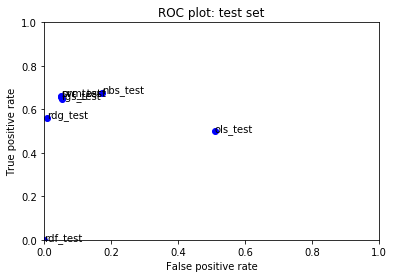

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 8 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1     

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = prc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.1038095894617443


In [25]:
raw_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,punc_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42,5
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112,3
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,1


In [26]:
my_submission.head()

,id,prediction
0,0000997932d777bf,False
1,000103f0d9cfb60f,False
2,000113f07ec002fd,False
3,0001b41b1c6bb37e,False
4,0001d958c54c6e35,False


In [27]:
my_submission.shape

(159571, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation